In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Partisan-Responses-master')

Import libraries

In [2]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

Helper functions

In [3]:
def read_full_speech(filepath):
    """
    Load into a dataframe the data from a text file in hein-bound
    :param filepath: filepath
    :return: speeches dataframe
    """
    with open(filepath, errors="ignore") as f:
        speech = f.readlines()
        speech = [s.strip() for s in speech]
        speech = [[s[:s.find('|')], s[s.find('|') + 1:]] for s in speech]
        speech_df = pd.DataFrame(speech[1:], columns=speech[0])
    return speech_df

def read_speakermap(filepath):
    """
    Load into a dataframe the speaker map from a text file in hein-bound
    :param filepath: filepath
    :return: speakermap dataframe
    """
    with open(filepath, errors="ignore") as f:
        speakermap_df = pd.read_table(f, delimiter = "|")
    return speakermap_df

def merge_speech_speaker(speech_df, speaker_df):
    """
    Merge a dataframe containing speeches with one containing the speakermap
    :param speech_df: speeches dataframe
    :param speaker_df: speakermap dataframe
    :return: merged dataframe
    """
    speech_df = speech_df.astype({"speech_id": type(speaker_df.loc[:,'speech_id'][0])})
    return speaker_df.merge(speech_df, on="speech_id", how="left")

def get_speeches_filename(idx):
    """
    Returns the name of the speeches file given an index
    :param idx: index
    :return: filename
    """
    return "speeches_{}.txt".format(idx)

def get_speakermap_filename(idx):
    """
    Returns the name of the speakermap file given an index
    :param idx: index
    :return: filename
    """
    return "{}_SpeakerMap.txt".format(idx)
def change_comma(speech):
    """
    Fixes comma issues due to OCR errors
    :param speech: text of the speech
    :return: corrected text
    """
    return re.sub("\.(?=\s[a-z0-9]|\sI[\W\s])", ",", speech)

Prepare topic phrase and stemmer

In [4]:
DATAPATH = "../hein-bound/topic_phrases.txt"
topic_phrases = pd.read_table(DATAPATH, sep = "|")

In [5]:
print(len(topic_phrases))
print(topic_phrases.head())
topic_words = set(topic_phrases['phrase'])

7555
     topic           phrase
0  alcohol     abus alcohol
1  alcohol     alcohol abus
2  alcohol  alcohol beverag
3  alcohol  alcohol content
4  alcohol     alcohol drug


In [6]:
ps = PorterStemmer()

#### Get questions and answers from all years

In [7]:
start_time = time.time()

questions = []
parties = []
for i in range(106, 112):  #final range?
    edition = str(i).zfill(3)
    no = 0

    # read speeches 
    speech_df = read_full_speech(get_speeches_filename(edition))
    speaker_df = read_speakermap(get_speakermap_filename(edition))
    final_df = merge_speech_speaker(speech_df, speaker_df)

    for j in tqdm(range(len(final_df))):
        # change comma in speech (OCR error) 
        question = change_comma(str(final_df.iloc[j].speech))
        # tokenize question speech
        quest_sents = nltk.sent_tokenize(question)
        # select question sentences from speech
        party=final_df.iloc[j].party
        for q in quest_sents:
            words = word_tokenize(q)
            words = [ps.stem(w.lower()) for w in words]
            stemmed_q = ' '.join(words)
            if any(phrase in stemmed_q for phrase in topic_words):
                questions.append(question)
                parties.append(party)
                no += 1
                break          
    print("finished file {}. {} pairs found".format(edition, no))
df = pd.DataFrame(list(zip(questions,parties)), columns =['Speech', 'Party'])

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

100%|█████████████████████████████████████████████████████████████████████████| 141407/141407 [14:41<00:00, 160.41it/s]


finished file 106. 58394 pairs found


100%|█████████████████████████████████████████████████████████████████████████| 116415/116415 [11:44<00:00, 165.27it/s]


finished file 107. 47803 pairs found


100%|█████████████████████████████████████████████████████████████████████████| 125664/125664 [12:26<00:00, 168.34it/s]


finished file 108. 52659 pairs found


100%|█████████████████████████████████████████████████████████████████████████| 119506/119506 [12:10<00:00, 163.56it/s]


finished file 109. 52532 pairs found


100%|█████████████████████████████████████████████████████████████████████████| 133182/133182 [13:47<00:00, 160.87it/s]


finished file 110. 58011 pairs found


100%|█████████████████████████████████████████████████████████████████████████| 112550/112550 [11:01<00:00, 170.05it/s]


finished file 111. 52966 pairs found


'01:16:03'

In [8]:
df.to_pickle("all_speeches.pkl")

In [9]:
df.head(15)

,Questions,Party
0,"Mr. President, as all Members are aware, I hav...",R
1,"Mr. President, I send five Senate resolutions ...",R
2,"Mr. President, during the impeachment trial of...",R
3,"Mr. President, I appreciate the statement of t...",D
4,"Mr. President, I ask unanimous consent that ac...",R
5,"Mr. President, for those of us granted the rar...",D
6,"Mr. President, I want to welcome all the Senat...",R
7,"Mr. President, I wanted to take just a moment ...",D
8,President Clinton has proposed at a meeting I ...,D
9,"Mr. President, it is a great honor and privile...",R


### Dataset Analysis

In [10]:
df = pd.read_pickle("all_speeches.pkl")

In [11]:
no_sentences = []
for i in range(len(df)):
    answer = df.iloc[i].Questions
    sents = nltk.sent_tokenize(answer)
    no_sentences.append(len(sents))

(array([11050.,  9800.,  8985.,  9090.,  9570., 10249., 10791., 11160.,
        11280., 10715., 10292.,  9726.,  9509.,  8752.,  8327.,  7891.,
         7300.,  6904.,  6632.,  6228.,  5970.,  5503.,  5176.,  4972.,
         4739.,  4486.,  4235.,  4114.,  3784.,  3680.,  3425.,  3318.,
         3100.,  2988.,  2814.,  2669.,  2439.,  2452.,  2195.,  2054.,
         2049.,  1944.,  1864.,  1691.,  1596.,  1570.,  1503.,  1414.,
         1283.,     0.,  1276.,  1211.,  1087.,  1069.,  1004.,  1031.,
          859.,   871.,   895.,   794.,   831.,   782.,   716.,   664.,
          727.,   675.,   660.,   586.,   542.,   599.,   578.,   475.,
          543.,   448.,   441.,   462.,   458.,   402.,   402.,   397.,
          373.,   368.,   346.,   363.,   333.,   324.,   327.,   312.,
          296.,   278.,   266.,   295.,   284.,   251.,   218.,   252.,
          250.,   235.,   213.,   234.]),
 array([  2.  ,   2.98,   3.96,   4.94,   5.92,   6.9 ,   7.88,   8.86,
          9.84,  10.82

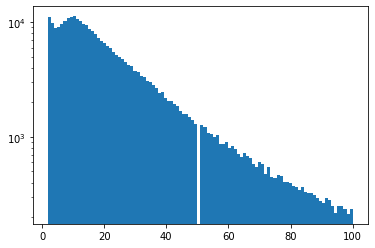

In [12]:
plt.hist(no_sentences, bins=100, range=(2, 100), log=True)

## Sentence Removal
In this section, we continue preprocess speeches with the aim of removing administrative phrases and sentencese, e.g. "Mr. Speker", "I reserve the balance of my time"

In [ ]:
def remove_wordy(s, wordy_list):
    for i in wordy_list:
        s=s.replace(i, "")
    return s

Remove short sentences

In [ ]:
repeat_short_sent = df['Speech'].apply(lambda s: s.split(",")).explode().value_counts()
repeat_short_sent = repeat_short_sent[repeat_short_sent>=10]
repeat_short_sent_df = pd.DataFrame(data = {"sent":repeat_short_sent.index, "counts":repeat_short_sent})
repeat_short_sent_df = repeat_short_sent_df[repeat_short_sent_df['sent'].apply(lambda x: len(x.split())>1)]

In [ ]:
thres = np.quantile(repeat_short_sent_df['counts'], 0.99)
to_remove = repeat_short_sent_df['sent'][repeat_short_sent_df['counts']>=thres].tolist()
to_remove = [i+"," for i in to_remove]

In [ ]:
df['Speech']  = df['Speech'].apply(lambda s: remove_wordy(s,to_remove))

Further remove long sentences

In [ ]:
repeat_long_sent = df['Speech'].apply(lambda s: [" ".join(i.split()) for i in s.split(".") if len(i.split())>1]).explode().value_counts()
repeat_long_sent = repeat_long_sent[repeat_long_sent>=10]
thres = np.quantile(repeat_long_sent, 0.99)
to_remove_long = repeat_long_sent[repeat_long_sent>=thres].index.tolist()
to_remove_long = [i+"." for i in to_remove_long]
to_remove_long[1:10]

In [ ]:
df['Speech']  = df['Speech'].apply(lambda s: remove_wordy(s,to_remove_long))
df['Speech'] = df['Speech'].apply(lambda s: " ".join(s.split()))

In [ ]:
# Remove 1-sent or 2-sent Speeches
speechlen = df["Speech"].apply(lambda x: len(nltk.sent_tokenize(x)))
final_df = df[speechlen > 2]
pickle.dump(final_df, "all_speech_sentence_filtered.pkl")

Result in 298792 speeches